# Train HoVer-Net

In this notebook, we will train HoVer-Net model to perform nucleus detection and classification, using data from PanNuke dataset. 

This notebook should be a good reference for how to do a full workflow using `PathML` and `PyTorch`

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from tqdm import tqdm
import albumentations as A

## Load HoVer-Net Model

## Data augmentation

Data augmentation is the process of applying random transformations to the data before feeding it to the network. This introduces some noise and can help improve model performance by reducing overfitting. For example, each image can be randomly rotated by 90 degrees - the idea is that this would force the network to learn representations which are robust to rotation. 

Importantly, whatever transform is applied to the image also needs to be applied to the corresponding mask! 

We'll use the [Albumentations](http://albumentations.ai/) library to handle data augmentation.
You can also write custom data augmentations, but albumentations and other similar libraries (e.g. torchvision.transforms) are convenient because they automatically handle masks in the augmentation pipeline. 

However, because our masks have multiple channels, they are not natively supported by Albumentations. So we'll wrap each transform in the `wrap_transform_multichannel()` utility function which will make it compatible.

In [2]:
from pathml.ml.utils import wrap_transform_multichannel

In [3]:
n_classes_pannuke = 6

# data augmentation transform 
hover_transform = A.Compose(
    [A.VerticalFlip(p=0.5), 
     A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5),
     A.GaussianBlur(p=0.5),
     A.MedianBlur(p=0.5)], 
    additional_targets = {f"mask{i}" : "mask" for i in range(n_classes_pannuke)}
)

transform = wrap_transform_multichannel(hover_transform)

## Load PanNuke dataset

In [4]:
from pathml.datasets.pannuke import PanNukeDataModule

In [5]:
pannuke = PanNukeDataModule(
    data_dir="../data/pannuke/", 
    download=False,
    nucleus_type_labels=True, 
    batch_size=8, 
    hovernet_preprocess=True,
    split=1,
    transforms=transform
)

train_dataloader = pannuke.train_dataloader
valid_dataloader = pannuke.valid_dataloader
test_dataloader = pannuke.test_dataloader

Let's visualize what the inputs to HoVer-Net model look like:

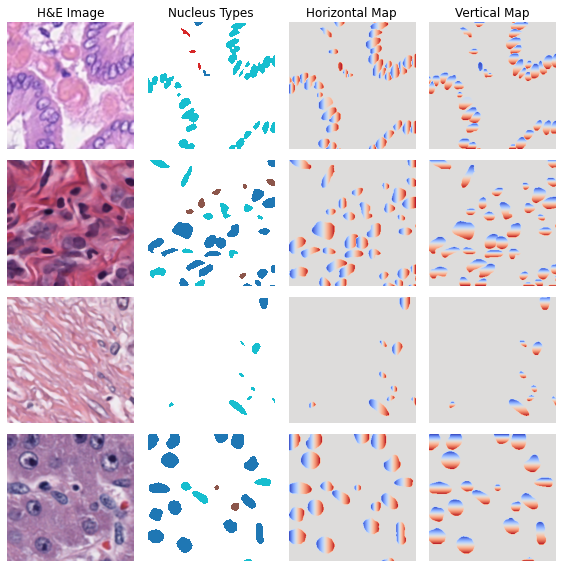

In [7]:
images, masks, hvs, types = next(iter(train_dataloader))

n = 4
fig, ax = plt.subplots(nrows=n, ncols=4, figsize = (8, 8))

cm_mask = copy.copy(cm.get_cmap("tab10"))
cm_mask.set_bad(color='white')

for i in range(n):
    im = images[i, ...].numpy()
    ax[i, 0].imshow(np.moveaxis(im, 0, 2))
    m = masks.argmax(dim=1)[i, ...]
    m = np.ma.masked_where(m == 5, m)
    ax[i, 1].imshow(m, cmap = cm_mask)
    ax[i, 2].imshow(hvs[i, 0, ...], cmap = 'coolwarm')
    ax[i, 3].imshow(hvs[i, 1, ...], cmap = 'coolwarm')
    
for a in ax.ravel(): a.axis("off")
for c,v in enumerate(["H&E Image", "Nucleus Types", "Horizontal Map", "Vertical Map"]):
    ax[0, c].set_title(v)
    
plt.tight_layout()
plt.show()

## Train HoVer-Net Model

Now we are ready to train the HoVer-Net model.  
To train a model in PyTorch, we need to write a training loop.  
[This tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is a good reference.

#### Training with multi-GPU

We use GPUs for training the model.

When using GPUs with PyTorch, there are a few things to keep in mind when writing the training loop. For example, we need to explicitly move data to the GPU by calling `.to(device)`.  
For multi-GPU, we also need to wrap our model object with `
torch.nn.DataParallel()`. 
PyTorch will then take care of all the tricky parts of distirbuting the processing across the GPUs.  

In [6]:
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda:0")
print(f"Device:\t\t{device}")

GPUs used:	4
Device:		cuda:0


In [7]:
from pathml.ml.hovernet import HoverNet, loss_hovernet

In [8]:
n_classes_pannuke = 6
hovernet = HoverNet(n_classes=n_classes_pannuke)

# wrap model to use multi-GPU
hovernet = torch.nn.DataParallel(hovernet)

In [9]:
# send model to GPU
hovernet.to(device);

#### Main training loop

In [10]:
from torch.optim.lr_scheduler import StepLR

In [11]:
# set up optimizer
opt = torch.optim.Adam(hovernet.parameters(), lr = 1e-4)
# learning rate scheduler to reduce LR by factor of 10 each 25 epochs
scheduler = StepLR(opt, step_size=25, gamma=0.1)

In [12]:
from pathml.ml.hovernet import post_process_batch_hovernet
from pathml.ml.utils import dice_score

In [14]:
n_epochs = 50

epoch_train_losses = {}
epoch_valid_losses = {}
epoch_train_dice = {}
epoch_valid_dice = {}

# main training loop
for i in tqdm(range(n_epochs)):
    minibatch_train_losses = []
    minibatch_train_dice = []
    
    # put model in training mode
    hovernet.train()
    
    for data in tqdm(train_dataloader):
        # send the data to the GPU
        images = data[0].float().to(device)
        masks = data[1].to(device)
        hv = data[2].float().to(device)
        tissue_type = data[3]
        
        # zero out gradient
        opt.zero_grad()
        
        # forward pass
        outputs = hovernet(images)
        
        # compute loss
        loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=6)
        
        # track loss
        minibatch_train_losses.append(loss.item())
        
        # also track dice score to measure performance
        preds_detection, preds_classification = post_process_batch_hovernet(outputs, n_classes=n_classes_pannuke)
        truth_binary = masks[:, -1, :, :] == 0
        dice = dice_score(preds_detection, truth_binary.cpu().numpy())
        minibatch_train_dice.append(dice)
        
        # compute gradients
        loss.backward()
        
        # step optimizer and scheduler
        opt.step()
        scheduler.step()
    
    # evaluate on validation data
    hovernet.eval()
    minibatch_valid_losses = []
    minibatch_valid_dice = []
    with torch.no_grad():
        for data in valid_dataloader:
            # send the data to the GPU
            images = data[0].float().to(device)
            masks = data[1].to(device)
            hv = data[2].float().to(device)
            tissue_type = data[3]
            
            # forward pass
            outputs = hovernet(images)
            
            # compute loss
            loss = loss_hovernet(outputs = outputs, ground_truth = [masks, hv], n_classes=6)
            
            # track loss
            minibatch_valid_losses.append(loss.item())

            # also track dice score to measure performance
            preds_detection, preds_classification = post_process_batch_hovernet(outputs, n_classes=n_classes_pannuke)
            truth_binary = masks[:, -1, :, :] == 0
            dice = dice_score(preds_detection, truth_binary.cpu().numpy())
            minibatch_valid_dice.append(dice)
    
    # track performance over training epochs
    epoch_train_losses.update({i : np.mean(minibatch_train_losses)})
    epoch_valid_losses.update({i : np.mean(minibatch_valid_losses)})
    epoch_train_dice.update({i : np.mean(minibatch_train_dice)})
    epoch_valid_dice.update({i : np.mean(minibatch_valid_dice)})

  0%|          | 0/332 [00:02<?, ?it/s]


KeyboardInterrupt: 